<a href="https://colab.research.google.com/github/srujayreddyv/CSUS-CSC219-MachineLeaning/blob/main/labs/CSC219Lab09_lstm_Srujay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 219 Machine Learning (Fall 2023)


# Lab 9: Recurrent Neural Networks


### Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network.

* Predictors/Inputs
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Convert dataframe to numpy array to create feature vectors (x) and expected output (y) with **to_xy**.

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Recurrent Neural Networks (a network that can remember the past input)

So far the neural networks that we’ve examined have always had forward connections.  ***these networks are called “feedforward.”***  

In Recurrent neural networks, "backward/recurrent connections" are also allowed. A "backward/recurrent connection" occurs when a connection is formed between a neuron and a neuron at the same level or a neuron at a previous level.


Most recurrent neural network architectures maintain "state" in the recurrent connections.  ***A recurrent neural network’s state acts as a short-term memory (context) for the neural network.***  Consequently, a recurrent neural network will not always produce the same output for a given input.

## Therefore, RNN is good at predicting over sequentail data (a sequnce of vectors)

### Notice that if we want to ***predict something over a sequence***,  we need to ***sequence*** our data by adding a dimension.  

### x should be of 3 dimensions.

In [ ]:
x = [
    [[32,1383],[41,2928],[39,8823],[20,1252],[15,1532]],
    [[35,8272],[32,1383],[41,2928],[39,8823],[20,1252]],
    [[37,2738],[35,8272],[32,1383],[41,2928],[39,8823]],
    [[34,2845],[37,2738],[35,8272],[32,1383],[41,2928]],
    [[32,2345],[34,2845],[37,2738],[35,8272],[32,1383]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

np.array(x).shape

(5, 5, 2)

# LSTM layers in TensorFlow

Long Short Term Neural Network (LSTM) are ***a type of recurrent unit***.  For TensorFlow, LSTM is provided as a layer type that can be combined with other layer types, such as dense.  

https://keras.io/layers/recurrent/


# LSTM Example for Classification

The following code creates the LSTM network.  This is an example of RNN classification.  The following code trains on a data set (x) with a max sequence size of 6 (columns) and 6 training elements (rows)

In [ ]:
import numpy as np
import tensorflow as tf



from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

# assume we have 4 classes
num_classes = 4

x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]


# Tensorflow likes float32 and int32
x = np.array(x, dtype=np.float32)

y = np.array([1,2,3,2,3,0], dtype=np.int32)


# Convert y2to dummy variables (one-hot encoding for classification problem)

y_2 = tf.keras.utils.to_categorical(y, num_classes)
y_2

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

### Like CNN,  input_shape is the shape of each sample

In [ ]:
# If numpy 1.20 gives you error, you may want to downgrade using pip install numpy==1.19.2

print('Build model...')
model = Sequential()

# each sequence has 6 members and each member is 1-dimentinal

#Like CNN,  input_shape is the shape of each sample

model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(6, 1)))
model.add(Dense(4, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


print('Train...')
model.fit(x, y_2,verbose=2, epochs=100)
pred = model.predict(x)

predict_classes = np.argmax(pred,axis=1)
print("Predicted classes:",predict_classes)
print("Expected classes:",y)

Build model...
Train...
Epoch 1/100
1/1 - 0s - loss: 1.4084 - accuracy: 0.1667
Epoch 2/100
1/1 - 0s - loss: 1.3983 - accuracy: 0.5000
Epoch 3/100
1/1 - 0s - loss: 1.3939 - accuracy: 0.3333
Epoch 4/100
1/1 - 0s - loss: 1.3923 - accuracy: 0.3333
Epoch 5/100
1/1 - 0s - loss: 1.3812 - accuracy: 0.3333
Epoch 6/100
1/1 - 0s - loss: 1.3725 - accuracy: 0.3333
Epoch 7/100
1/1 - 0s - loss: 1.3711 - accuracy: 0.3333
Epoch 8/100
1/1 - 0s - loss: 1.3630 - accuracy: 0.3333
Epoch 9/100
1/1 - 0s - loss: 1.3554 - accuracy: 0.5000
Epoch 10/100
1/1 - 0s - loss: 1.3459 - accuracy: 0.5000
Epoch 11/100
1/1 - 0s - loss: 1.3359 - accuracy: 0.5000
Epoch 12/100
1/1 - 0s - loss: 1.3404 - accuracy: 0.5000
Epoch 13/100
1/1 - 0s - loss: 1.3240 - accuracy: 0.5000
Epoch 14/100
1/1 - 0s - loss: 1.3216 - accuracy: 0.5000
Epoch 15/100
1/1 - 0s - loss: 1.3191 - accuracy: 0.5000
Epoch 16/100
1/1 - 0s - loss: 1.3256 - accuracy: 0.3333
Epoch 17/100
1/1 - 0s - loss: 1.2939 - accuracy: 0.3333
Epoch 18/100
1/1 - 0s - loss: 1.2

### Let's predict any ad hoc sequence using trained model

For example  [[0],[0],[0],[0],[0],[1]]

In [ ]:
x = np.array([[0],[0],[0],[0],[0],[1]])

x.shape

(6, 1)

In [ ]:
x = np.array(x, dtype=np.float32)

pred = model.predict(x)

print(x)

print("Prediction:", np.argmax(pred[0]))

ValueError: in user code:

    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    c:\Users\haiquan.chen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]


### Why?  

### Remeber x must be a 3D array!!

In [ ]:
x = np.array([[[0],[0],[0],[0],[0],[1]]])

x = np.array(x, dtype=np.float32)

pred = model.predict(x)

print(x.shape)

print("Prediction:", np.argmax(pred[0]))

(1, 6, 1)
Prediction: 0


# LSTM Example for Regression

An example of RNN regression to predict sunspots.  The data files needed for this example can be found at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)

http://www.sidc.be/silso/infosndtot

The following code is used to load the sunspot file:

In [ ]:
import pandas as pd
import os

path = "./data/"

filename = os.path.join(path,"SN_d_tot_V2.0.csv")
names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 'sn_error', 'obs_num']
df = pd.read_csv(filename, sep=';', header=None, names=names, index_col=False)

# index_col=False forces pandas not to use the first column as the index

df[0:10]

# -1 means NA

,year,month,day,dec_year,sn_value,sn_error,obs_num
0,1818,1,1,1818.001,-1,-1.0,0
1,1818,1,2,1818.004,-1,-1.0,0
2,1818,1,3,1818.007,-1,-1.0,0
3,1818,1,4,1818.010,-1,-1.0,0
4,1818,1,5,1818.012,-1,-1.0,0
5,1818,1,6,1818.015,-1,-1.0,0
6,1818,1,7,1818.018,-1,-1.0,0
7,1818,1,8,1818.021,65,10.2,1
8,1818,1,9,1818.023,-1,-1.0,0
9,1818,1,10,1818.026,-1,-1.0,0


In [ ]:
# The missing values are marked by -1

df = df[(df['sn_value'] != -1) & (df['obs_num'] != 0)]

In [ ]:
df.shape

(69922, 7)

In [ ]:
df[0:15]

,year,month,day,dec_year,sn_value,sn_error,obs_num
7,1818,1,8,1818.021,65,10.2,1
12,1818,1,13,1818.034,37,7.7,1
16,1818,1,17,1818.045,77,11.1,1
17,1818,1,18,1818.048,98,12.6,1
18,1818,1,19,1818.051,105,13.0,1
24,1818,1,25,1818.067,25,6.3,1
27,1818,1,28,1818.075,38,7.8,1
28,1818,1,29,1818.078,20,5.7,1
33,1818,2,3,1818.092,17,5.2,1
35,1818,2,5,1818.097,20,5.7,1


### Now, we want to predict a SN value based on the $N$ preceding values.  

In [ ]:
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("Training set has {} records.".format(len(spots_train)))
print("Test set has {} records.".format(len(spots_test)))

Training set has 63227 records.
Test set has 6695 records.


### Sequence data to create x and y in the format RNN likes.

In [ ]:
import numpy as np

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

In [ ]:
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (63216, 10, 1)
Shape of x_test: (6684, 10, 1)
Shape of y_train: (63216,)
Shape of y_test: (6684,)


In [ ]:
x_train[0:5]

array([[[ 65],
        [ 37],
        [ 77],
        [ 98],
        [105],
        [ 25],
        [ 38],
        [ 20],
        [ 17],
        [ 20]],

       [[ 37],
        [ 77],
        [ 98],
        [105],
        [ 25],
        [ 38],
        [ 20],
        [ 17],
        [ 20],
        [ 25]],

       [[ 77],
        [ 98],
        [105],
        [ 25],
        [ 38],
        [ 20],
        [ 17],
        [ 20],
        [ 25],
        [ 87]],

       [[ 98],
        [105],
        [ 25],
        [ 38],
        [ 20],
        [ 17],
        [ 20],
        [ 25],
        [ 87],
        [192]],

       [[105],
        [ 25],
        [ 38],
        [ 20],
        [ 17],
        [ 20],
        [ 25],
        [ 87],
        [192],
        [ 73]]])

In [ ]:
y_train[0:5]

array([ 25,  87, 192,  73,  82])

### Ready to train a RNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()

model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 1)))
model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=3)

Build model...
Train...
Epoch 1/3
1976/1976 - 8s - loss: 1348.4918 - val_loss: 433.0674
Epoch 2/3
1976/1976 - 8s - loss: 621.8448 - val_loss: 239.1213
Epoch 3/3
1976/1976 - 7s - loss: 618.8212 - val_loss: 414.4273


In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 20.35748903345908


## Stacking Several LSTM Layers

https://keras.io/layers/recurrent/


### Accessing the hidden state output   $\hat{y}$  for each time slice


It is possible to access the hidden state output $\hat{y}$ (the cell output) for each time slice, which can be useful when developing sophisticated recurrent neural network architectures, such as the encoder-decoder model. This can be done by setting the ***return_sequences parameter to True*** when defining the LSTM layer

***You must set return_sequences=True when stacking multiple LSTM layers.***



model = Sequential()

model.add(LSTM(..., return_sequences=True, input_shape=(...)))

model.add(LSTM(..., return_sequences=True))

model.add(LSTM(..., return_sequences=True))

model.add(LSTM(...))

model.add(Dense(...))

### Accessing the context values (internal state) $c$ for each time slice

***the return_state argument provides access to the context values (internal state) $c$ for each time slice***


For example, we can access both the sequence of hidden state output and the internal states at the same time.

This can be done as follows:

LSTM(..., return_sequences=True, return_state=True)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds



### Loading the IMDB Reviews Dataset

IMDB Reviews Dataset can be downloaded from the built-in datasets in Keras.  There are 25,000 samples of movie reviews for training and 25,000 samples for validation. Setting `max_features` to 20,000 means we are only considering the first 20,000 words and the rest of the words will have the out-of-vocabulary token. Each movie review has a positive or negative label.

The training and validation datasets will be loaded as lists with 25,000 elements.

In [ ]:
max_features = 20000

(train_data, train_labels), (val_data, val_labels) = tf.keras.datasets.imdb.load_data(num_words=max_features)

Displayed below is the third movie review. It is also a list, it contains 141 words, and as we can see the words in the dataset are already converted to tokens.

In [ ]:
# Display the third movie review
print('Number of words in the third review', len(train_data[2]))
print(train_data[2])

Number of words in the third review 141
[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 2, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 2, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113]


In [ ]:
# Display the first 10 labels
train_labels[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

### Preparing the Dataset

Let's pad the data using the `pad_sequences` function in Keras. Setting `maxlen` indicates to use the first 200 words in each movie review, and ignore the rest. Most movie reviews in the dataset are shorter than 200 words, however for those that are longer than 200 words some information will be lost. That is a tradeoff between computational expense and model performance.

We can see in the next cell that for the third reivew, which has a length of 141 words, the first 59 words are now 0, and the length is 200.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_data = pad_sequences(train_data, maxlen=200, padding='post')
val_data = pad_sequences(val_data, maxlen=200, padding='post')

In [ ]:
# Display the third movie review
print('Shape of the third padded review:', train_data[2].shape, '\n')
print(train_data[2])

Shape of the third padded review: (200,) 

[   1   14   47    8   30   31    7    4  249  108    7    4 5974   54
   61  369   13   71  149   14   22  112    4 2401  311   12   16 3711
   33   75   43 1829  296    4   86  320   35  534   19  263 4821 1301
    4 1873   33   89   78   12   66   16    4  360    7    4   58  316
  334   11    4 1716   43  645  662    8  257   85 1200   42 1228 2578
   83   68 3912   15   36  165 1539  278   36   69    2  780    8  106
   14 6905 1338   18    6   22   12  215   28  610   40    6   87  326
   23 2300   21   23   22   12  272   40   57   31   11    4   22   47
    6 2307   51    9  170   23  595  116  595 1352   13  191   79  638
   89    2   14    9    8  106  607  624   35  534    6  227    7  129
  113    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when when `return_sequences` is True.

The next cell implements the stacked LSTM architecture.

In [ ]:
import tensorflow as tf

# Hyperparameters

batch_size = 64
timesteps = 200

embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,391,489
Trainable params: 1,391,489
Non-

In [ ]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters we set, it will take around 2 minutes per epoch with the Colab GPU enabled.

In [ ]:
history = model.fit(train_data[0:500], train_labels[0:500], validation_data = (val_data[0:500], val_labels[0:500]), epochs=10)

Epoch 1/10
16/16 [==============================] - 11s 401ms/step - loss: 0.6939 - accuracy: 0.5020 - val_loss: 0.6926 - val_accuracy: 0.5220
Epoch 2/10
16/16 [==============================] - 5s 312ms/step - loss: 0.6831 - accuracy: 0.6480 - val_loss: 0.6836 - val_accuracy: 0.5680
Epoch 3/10
16/16 [==============================] - 5s 302ms/step - loss: 0.5491 - accuracy: 0.8220 - val_loss: 0.7261 - val_accuracy: 0.5780
Epoch 4/10
16/16 [==============================] - 5s 304ms/step - loss: 0.1780 - accuracy: 0.9580 - val_loss: 0.8558 - val_accuracy: 0.6780
Epoch 5/10
16/16 [==============================] - 5s 307ms/step - loss: 0.0485 - accuracy: 0.9900 - val_loss: 1.0984 - val_accuracy: 0.6880
Epoch 6/10
16/16 [==============================] - 5s 340ms/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 1.2590 - val_accuracy: 0.6720
Epoch 7/10
16/16 [==============================] - 6s 351ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3091 - val_accuracy: 0.6880
Epoch

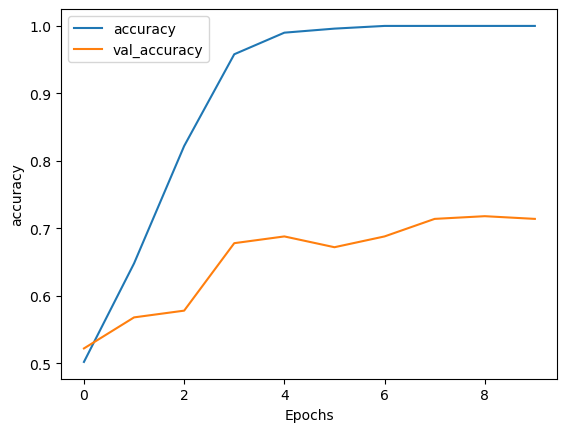

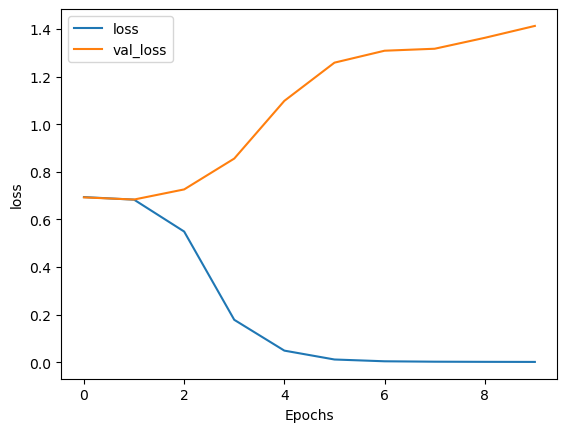

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)